# PLOTMAKER 
##### Make all plots for CST paper in this notebook

In [108]:
from context import * #
import torch
import pickle
import scipy
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import random
from MPS import MPS #
import random 
from EF_MPS_utils import * #
from stabilizer_mps_utils import * #
torch.set_default_dtype(torch.float64)
from IPython.display import clear_output
import timeit
from scipy.optimize import curve_fit

%matplotlib inline

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#generate random snapshots
def make_snapshot(rho0,L):
    comp_basis=paulis(pauli({i:'Z'}, n) for i in range(n))
    if math.inf>L>0:
        u=identity_map(n)
        for step in range(L):
            u=u.compose(random_brickwall_layer(n,step%2))
    elif L==0:
        u=random_pauli_map(n)
    else :
        u=random_clifford_map(n)
    rhof=rho0.to_map().compose(u).to_state()
    b=rhof.measure(comp_basis)[0]
    sigma=paulis(((-1)**(b[i]))*pauli({i:'Z'}, n) for i in range(n))
    return stabilizer_state(sigma).to_map().compose(u.inverse()).to_state()

#load reconstruction vector, return mps and boundary matrix
def load_rmps(n,d,Dw,Dr,t,acc,path='',device=torch.device('cpu')):
    if math.inf>t>0:
        filename='HaarReconstructionMPS_N=%d_d=%d_Dw=%d_Dr=%d_t=%d_%d.pt' % (n,d,Dw,Dr,t,acc)
        result=torch.load(path+filename,map_location=device)
        eigs,ut,Am=result["eigs"].to(device),result["ut"].to(device),result["Am"].to(device)
        rmps=r_vector(n,d,eigs,ut,Am)
        #check if there's a boundary tensor
        if "bdiag" in result :
            bdiag=result["bdiag"].to(device)
            rbdry=torch.diag(torch.tanh(bdiag))
        else :
            rbdry=None
    elif t==0 :
        rmps=MPS(torch.tensor([1.,-3./2.,-3./2.,9./4.]).reshape(1,1,1,4))
        rbdry=None
    else:
        #random Clifford case
        rbdry=torch.diag(torch.tensor([-1.,1.]))
        rmats=torch.zeros((1,2,2,4))
        rmats[0,0,0,0]=1
        rmats[0,1,1,3]=(1+d**(-n))**(2/n)
        rmps=MPS(rmats)
    return rmps,rbdry

#load ef mps 
def load_efmps(tmat,n,DwLoad,Dw,t,Wacc,path='',device=torch.device('cpu'),alpha=0.34657359028):
    if DwLoad>0:
        #load result
        result=torch.load('EFMPS_N=%d_d=%d_Dw1=%d_Dw2=%d_t=%d_%d.pt' % (n,2,DwLoad,Dw,t,Wacc),map_location=device)
        W=MPS(result["mats"].to(device)).to(device)
        return W
    else :
        if t<math.inf :
            W=MPS(product_state_mps(1,cell_size=2).mats.float())
            for step in range(t):
                W=ef_normalize(evolve_mps(tmat,W,Dw,(t-step-1)%2),n)
            W=W.to(device)
            return W
        else :
            #final ef state with slope alpha
            return ef_mps(n,2,alpha,0).to(device)
            
d=2
VX=torch.tensor([[[[1, 0], [0, 0]], [[1, 0], [0, 0]]], [[[1, 0], [0, 0]], [[d**2/(-1 + d**2), -(d/(-1 + d**2))], [-(d/(-1 + d**2)), 
    d**2/(-1 + d**2)]]]],dtype=torch.float64)
VX2=torch.einsum('abcd,efgh->aebfcgdh',VX,VX).view(4,4,4,4)

#return the onsite tensor for the EF of a Pauli operator
def pauliEF(supp, i):
    return torch.tensor([0,2],dtype=torch.float64).view(1,1,2) if i in supp else \
        torch.tensor([4,2],dtype=torch.float64).view(1,1,2)

#return EF of product state with on-site purity f
def mixedEF(f):
    return MPS(torch.tensor([1,f], dtype=torch.float64).view(1,1,1,2))

#combine neighboring onsite tensors
def coarseGrain(mps):
    return MPS(torch.tensordot(mps.mats[0],mps.mats[-1],dims=([1],[0])).transpose(1,2).reshape(1,mps.mats.shape[1],mps.mats.shape[2],-1))
    
#return EF tensor of ghz state
def ghzEF(n):
    au=torch.diag(torch.tensor([1,0,1],dtype=torch.float64))
    ad=torch.diag(torch.tensor([0,1,1],dtype=torch.float64))
    return MPS((torch.stack([au,ad],dim=2)/2**(1/n)).view(1,3,3,2))


#ef of cluster state
def clusterEF(n):
    a,b,zero=[0.5,0.5,0.5,0.5],[0.5,-0.5,-0.5,0.5],[0.,0.,0.,0.]
    T=torch.tensor([a,zero,zero,b],dtype=torch.float64)
    swap=torch.eye(4).reshape(2,2,2,2).transpose(2,3)
    swapid=torch.einsum('abcd,efgh->aebfcgdh',torch.eye(4).reshape(2,2,2,2),swap).reshape(16,16)
    au=kron(T,T)
    ad=swapid.double() @ kron(T,T) @ swapid.double()
    return MPS((torch.stack([au,ad],dim=2)).view(1,16,16,2))

#form matrix from 4-degree vertex and surroudning tensors
def merge4matrix(vertex,aa,bb,cc,dd):
    size=aa.size(0)*bb.size(0)*cc.size(0)*dd.size(0)
    m=torch.tensordot(vertex,aa,dims=([0],[2]))
    m=torch.tensordot(m,bb,dims=([0],[2]))
    m=torch.tensordot(m,cc,dims=([0],[2]))
    m=torch.tensordot(m,dd,dims=([0],[2]))
    m=m.permute(0,2,4,6,1,3,5,7).reshape(size,size) 
    return m

#perform median of means estimation given numpy array
def MOM(samples,numgroups,axis=0):
    sections=numpy.array_split(samples,numgroups,axis=axis)
    means=[numpy.mean(sec,axis=axis) for sec in sections]
    return numpy.median(numpy.stack(means,axis=0),axis=0)

#predicted scaling form as a function of circuit depth x
def scalingForm(x,n):
    return (1 + (-1 + 2**2**x + 4**2**x)**(n/2**x))/(2**n + 4**n)

device

device(type='cpu')

In [2]:
n=22
Lmax=6
wgts=list(range(22))
path=''
DwList=[1,4,4,6,6,6]
DrList=[1,4,4,6,6,6]
DwTrainList=[-1,-1,-1,8,20,20]
DwTrainAcc=[-1,-1,-1,6,5,5]
accList=[-1,7,7,5,3,3]
OpSupps=[list(range(wgt)) for wgt in wgts]
#results
shadowNorms=numpy.zeros((Lmax,len(wgts)))
for L in range(Lmax):
    #load r
    rmps,rbdry=load_rmps(n,2,DwList[L],DrList[L],L,accList[L],path=path,device=device)
    W=load_efmps(ef_haar_tm(2),n,DwTrainList[L],DwList[L],L,DwTrainAcc[L],path=path,device=device)
    W2=MPS(torch.tensordot(W.mats[0],W.mats[-1],dims=([1],[0])).transpose(1,2).reshape(1,W.mats.shape[1],W.mats.shape[2],4))
    size=W2.mats.shape[1]*(rmps.mats.shape[1])**2
    for op in range(len(wgts)):
        prod=torch.eye(size).to(device)
        supp=OpSupps[op]
        for uc in range(n//2):
            wpauli=kron(pauliEF(supp,2*uc).view(1,2),pauliEF(supp,2*uc+1).view(1,2)).view(1,1,4)
            prod=prod @ merge4matrix(VX2,rmps.mats[0],rmps.mats[0],W2.mats[0].double(),wpauli)
        if not rbdry==None :
            prod = prod @ kron(kron(rbdry,rbdry),torch.eye(W2.mats.shape[1]))
        shadowNorms[L,op]=prod.trace()

In [137]:
numpy.ndarray.flatten(shadowNorms).tofile('data_for_mathematica/shadowNorms.dat')

In [143]:
shadowNorms.dtype

dtype('float64')

In [3]:
#sys parameters
n=22
Lmax=6
wgts=list(range(10))
path=''
DwList=[1,4,4,6,6,6]
DrList=[1,4,4,6,6,6]
DwTrainList=[-1,-1,-1,8,20,20]
DwTrainAcc=[-1,-1,-1,6,5,5]
accList=[-1,7,7,5,3,3]
testOps=[pauli('Z'*(wgt) + 'I'*(n-wgt)) for wgt in wgts]
OpSupps=[list(range(wgt)) for wgt in wgts]
M=50000
rho0=ghz_state(n)
psi0=cluster_state(n)
#results
preds_ghz=numpy.zeros((Lmax,len(wgts),M))
preds_cluster=numpy.zeros((Lmax,len(wgts),M))
for L in range(Lmax):
    #load r
    rmps,rbdry=load_rmps(n,2,DwList[L],DrList[L],L,accList[L],path=path,device=device)
    coeffs=torch.zeros(len(wgts))
    for os in range(len(wgts)):
        osmps=support_vector(OpSupps[os],n,factor=4)
        #print(osmps.mats.dtype, rmps.mats.dtype)
        coeffs[os]=rmps.dot2(osmps,cell_num=1,bdry=rbdry).item().real
    for snap in range(M):
        state_ghz=make_snapshot(rho0,L)
        state_cluster=make_snapshot(psi0,L)
        for i in range(len(wgts)):
            preds_ghz[L,i,snap]=coeffs[i]*state_ghz.expect(paulis(testOps[i]))[0]
            preds_cluster[L,i,snap]=coeffs[i]*state_cluster.expect(paulis(testOps[i]))[0]

In [138]:
numpy.ndarray.flatten(preds_ghz).tofile('data_for_mathematica/preds_ghz.dat')
numpy.ndarray.flatten(preds_cluster).tofile('data_for_mathematica/preds_cluster.dat')

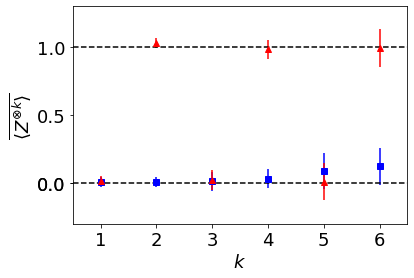

In [127]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18)

fig,ax=plt.subplots()

xmax=7
ys_ghz=MOM(preds_ghz,1,axis=2)
ys_ghz_err=numpy.std(preds_ghz,axis=2)/numpy.sqrt(M)
ys_cluster=MOM(preds_cluster,1,axis=2)
ys_cluster_err=numpy.std(preds_cluster,axis=2)/numpy.sqrt(M)

ax.axhline(y=0,color='k',linestyle='--')
ax.axhline(y=1,color='k',linestyle='--')

#ax.plot(list(range(xmax)), [x%2 for x in range(1,xmax+1)],'k*--') #exact answer
#ax.plot(list(range(xmax)), [0]*xmax, 'k*--')
for L in [3]:
    ax.errorbar(list(range(xmax)),ys_cluster[L,:xmax],yerr=2*ys_cluster_err[L,:xmax],fmt='bs',label=r'$L=%d$' % L)
    ax.errorbar(list(range(xmax)),ys_ghz[L,:xmax],yerr=2*ys_ghz_err[L,:xmax],fmt='r^',label=r'$L=%d$' % L)

#ax.plot(list(range(len(wgts))),shadowNorms[4]/shadowNorms[0],'ko-',label=r'$L=4$')

#ax.legend()
ax.set_xlabel(r'$ k $')
ax.set_ylabel(r'$ \overline{\langle Z^{\otimes k} \rangle} $')
ax.set_yscale("linear")
ax.set_ylim(-0.3,1.3)
ax.set_xlim(0.5,xmax-0.5)
ax.set_yticks([0,0,0.5,1])
ax.set_xticks(list(range(1,xmax)))
#plt.savefig("pauli_obs_ghz_cluster.pdf",bbox_inches='tight')

In [139]:
numpy.ndarray.flatten(ys_ghz).tofile('data_for_mathematica/ys_ghz.dat')
numpy.ndarray.flatten(ys_cluster).tofile('data_for_mathematica/ys_cluster.dat')
numpy.ndarray.flatten(ys_ghz_err).tofile('data_for_mathematica/ys_ghz_err.dat')
numpy.ndarray.flatten(ys_cluster_err).tofile('data_for_mathematica/ys_cluster_err.dat')

In [146]:
ys_cluster_err.dtype

dtype('float64')

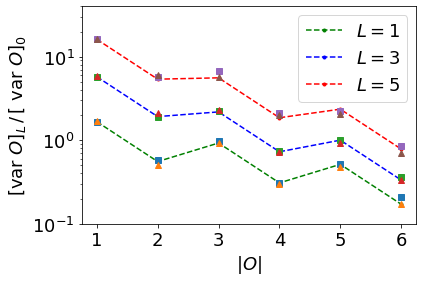

In [131]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18)

fig,ax=plt.subplots()
xmax=7
xvals=list(range(1,xmax))
colors=['g','b','r']
Lvals=[1,3,5]

for i in range(len(Lvals)):
    L,c=Lvals[i],colors[i]
    sn_exact=shadowNorms[L,1:xmax]/shadowNorms[0,1:xmax]
    sn_ghz=(ys_ghz_err[L,1:xmax]/ys_ghz_err[0,1:xmax])**2
    sn_cluster=(ys_cluster_err[L,1:xmax]/ys_cluster_err[0,1:xmax])**2

    ax.plot(xvals,sn_exact,c+'.--',label=r'$L=%d$'%L)
    ax.plot(xvals,sn_cluster,'s')
    ax.plot(xvals,sn_ghz,'^')

ax.legend()
ax.set_xlabel(r'$ | O | $')
ax.set_ylabel(r'$ [$var $O]_{L} \,/\, [$ var $O]_{0} $')
ax.set_yscale("log")
ax.set_ylim(0.1,40)
#ax.set_xticks(list(range(0,xmax,2)))
plt.savefig("pauli_var_exact_cluster_ghz.pdf",bbox_inches='tight')

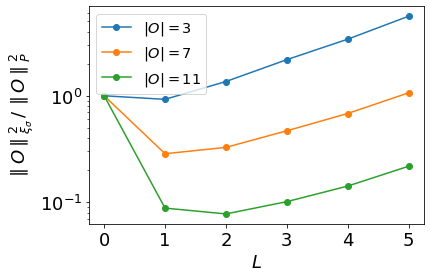

In [68]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18)

fig,ax=plt.subplots()
plt_wgts=[3,7,11]
pts=[]
for wg in plt_wgts:
    pts.append([(shadowNorms[i,wg] / shadowNorms[0,wg]) for i in range(0,Lmax)])
    ax.plot(list(range(0,Lmax)),pts[-1],'o-',label=r'$|O|=%d$'%wg)

ax.legend(prop={'size':14.5})
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$ \parallel O \parallel_{\xi_\sigma}^2 \,/\, \parallel O \parallel_{P}^2  $')
ax.set_yscale("log")
plt.savefig("pauli_var_exact_cluster_ghz_2.pdf",bbox_inches='tight')

In [153]:
#sys parameters 
L=3
nvals=[6,10,14,18,22]
accList=[8,8,5,5,5]
fidelities=[]
for i in range(len(nvals)) : 
    directory='n=%d_t=%d_fids/' % (nvals[i],L)
    fname='cluster_fids_n=%d_t=%d_%d.csv' % (nvals[i],L,accList[i])
    fidelities.append(numpy.loadtxt(directory + fname))

In [141]:
numpy.ndarray.flatten(numpy.concatenate(fidelities, axis=0)).tofile('data_for_mathematica/fids_vs_n.dat')

cluster fit: [9.82828608e-06 3.97779569e-01]


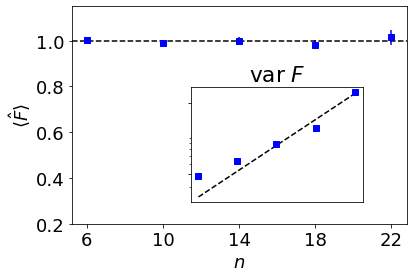

In [154]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18)

fig,ax=plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.4, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ys,yerrs=[],[]
for i in range(len(fidelities)) :
    fids=fidelities[i]
    ys.append(MOM(fids,1,axis=0))
    yerrs.append(numpy.std(fids)/numpy.sqrt(len(fids)))

ax.axhline(y=1,color='k',linestyle='--')
ax.errorbar(nvals,ys,yerr=2*numpy.array(yerrs),fmt='bs',label=r'cluster')

def fitfunc(x,b,c):
    return numpy.exp(c*x/(L+1)**0.72)*b

popt, pcov = curve_fit(fitfunc, numpy.array(nvals), numpy.array(yerrs)**2, p0=[1E-5,0.47])
print('cluster fit:',popt)
xrange=numpy.arange(min(nvals),max(nvals)+0.2,0.1)
ax2.plot(xrange, fitfunc(xrange, *popt),'k--')
ax2.plot(nvals,numpy.array(yerrs)**2,'bs',label=r'cluster')

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\langle \hat{F} \rangle$')
ax.set_yscale("linear")
ax.set_ylim(0.2,1.15)
ax2.set_yscale("log")
ax2.set_xticks([])
ax2.set_yticks([4E-5,2E-4])
ax2.set_title(r'var $F$')
#ax.legend(prop={'size':17})
#ax.set_yticks([0.9,1,1.1])
ax.set_xticks(nvals)
#plt.savefig("fid_cluster_vs_n_2.pdf",bbox_inches='tight')

In [156]:
numpy.ndarray.flatten(numpy.array(ys)).tofile('data_for_mathematica/yvn.dat')
numpy.ndarray.flatten(numpy.array(yerrs)).tofile('data_for_mathematica/yerrvn.dat')

In [159]:
#sys parameters 
n=22
Lvals=[0,1,2,3,4,5]
accList=[12,7,7,5,3,3]
fidelities=[]
fidelities2=[]
for i in range(len(Lvals)) : 
    directory='n=%d_t=%d_fids/' % (n,Lvals[i])
    fname='fids_n=%d_t=%d_%d.csv' % (n,Lvals[i],accList[i])
    fidelities.append(numpy.loadtxt(directory + 'cluster_' + fname))
    fidelities2.append(numpy.loadtxt(directory + fname))

In [142]:
numpy.ndarray.flatten(numpy.concatenate(fidelities, axis=0)).tofile('data_for_mathematica/fids_cluster_vs_L.dat')
numpy.ndarray.flatten(numpy.concatenate(fidelities2, axis=0)).tofile('data_for_mathematica/fids_ghz_vs_L.dat')

In [152]:
numpy.ndarray.flatten(numpy.concatenate(fidelities, axis=0)).shape[0] // 50000

5

cluster fit: [1.54592979e-01 6.78934293e-08]


<ipython-input-160-d8e40eb8c72a>:29: RuntimeWarning: overflow encountered in exp
  return numpy.exp(0.47*n/(x+1)**a)*b


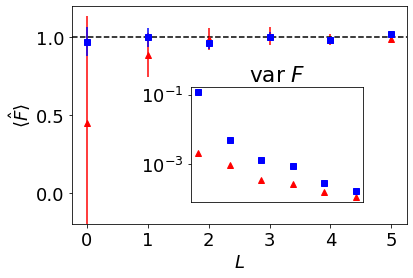

In [160]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18)

fig,ax=plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.4, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ys,yerrs=[],[]
ys2,yerrs2=[],[]
for i in range(len(fidelities)) :
    fids,fids2=fidelities[i],fidelities2[i]
    ys.append(MOM(fids,12,axis=0))
    yerrs.append(numpy.std(fids)/numpy.sqrt(len(fids)))
    ys2.append(MOM(fids2,12,axis=0))
    yerrs2.append(numpy.std(fids2)/numpy.sqrt(len(fids2)))

ys,yerrs,ys2,yerrs2=numpy.array(ys),numpy.array(yerrs),numpy.array(ys2),numpy.array(yerrs2)
ax.axhline(y=1,color='k',linestyle='--')
ax.errorbar(Lvals,ys2,yerr=2*yerrs2,fmt='r^',label=r'ghz')
ax.errorbar(Lvals,ys,yerr=2*yerrs,fmt='bs',label=r'cluster')

def fitfunc(x,a,b):
    return numpy.exp(0.47*n/(x+1)**a)*b

popt, pcov = curve_fit(fitfunc, numpy.array(Lvals), yerrs**2, p0=[0.72,1E-5])
print('cluster fit:',popt)
xrange=numpy.arange(min(Lvals),max(Lvals)+0.2,0.1)
#ax2.plot(xrange, fitfunc(xrange, *popt),'k--')

ax2.plot(Lvals,yerrs**2,'r^',label=r'cluster')
ax2.plot(Lvals,yerrs2**2,'bs',label=r'ghz')
ax2.set_yscale("log")
ax2.set_xticks([])
ax2.set_title(r'var $F$')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\langle \hat{F} \rangle$')
ax.set_yscale("linear")
ax.set_ylim(-0.2,1.2)
#ax.legend(prop={'size':17})
ax.set_yticks([0,0.5,1])
#plt.savefig("fids_cluster_and_ghz.pdf",bbox_inches='tight')

In [161]:
numpy.ndarray.flatten(ys).tofile('data_for_mathematica/cluster-vl.dat')
numpy.ndarray.flatten(yerrs).tofile('data_for_mathematica/cluster-err-vl.dat')
numpy.ndarray.flatten(ys2).tofile('data_for_mathematica/ghz-vl.dat')
numpy.ndarray.flatten(yerrs2).tofile('data_for_mathematica/ghz-err-vl.dat')

In [ ]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=25)

fig,ax=plt.subplots()

func,p0=func3,p3

#load actual variance data
ys,ysghz=[],[]
M=50000
for i in range(len(fidelities)) :
    ys.append(numpy.var(fidelities[i]) / M)
    ysghz.append(numpy.var(fidelities2[i]) / M)
    
ys=numpy.array(ys)
ysghz=numpy.array(ysghz)
#set xvalues to study
xplot = numpy.array(list(range(len(fidelities))))
xfit = numpy.array(list(range(len(fidelities))))[1:]

#fit curves
popt, pcov = curve_fit(func, xfit, numpy.log(ys[xfit]), p0=p0)
print('cluster fit:',popt)
ax.plot(numpy.arange(min(xplot),max(xplot)+0.2,0.1), numpy.exp(func(numpy.arange(min(xplot),max(xplot)+0.2,0.1), *popt)),'--')
#fit curves
popt, pcov = curve_fit(func, xfit, numpy.log(ysghz[xfit]), p0=p0)
print('ghz fit:',popt)
ax.plot(numpy.arange(min(xplot),max(xplot)+0.2,0.1), numpy.exp(func(numpy.arange(min(xplot),max(xplot)+0.2,0.1), *popt)),'--')

ax.plot(xplot,ys,'ko',label=r'cluster')
ax.plot(xplot,ysghz,'ro',label=r'ghz')

#print(shadowNorms[0,1:(len(Lvals)+1)]/ys)
#ax.axhline(y=numpy.sqrt(shadowNorms[0,-1])/numpy.sqrt(len(fids)),color='k',linestyle='--')
#ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\langle (\delta \hat{F})^2 \rangle / M$')
ax.set_yscale("log")
ax.legend(prop={'size':20})
ax.set_xticks(list(range(max(xplot)+1)))
#ax.set_yticks([1E-2,1E-1])
#plt.savefig("variance_comparison_cluster_ghz.pdf",bbox_inches='tight')
#ax.set_ylim(-0.05,0.2)